<a href="https://colab.research.google.com/github/MajiroZ/for_git_study/blob/master/Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##【問題1】全結合層のクラス化

In [12]:
# 全結合層をクラス化する

import numpy as np

class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.X = None
        self.dW = None
        self.dB = None

    def forward(self, X):
        self.X = X
        out = np.dot(X, self.W) + self.B
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.dB = np.sum(dout, axis=0)
        self = self.optimizer.update(self)
        return dx

##【問題2】初期化方法のクラス化

In [13]:
# 全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにする

import numpy as np

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

##【問題3】最適化手法のクラス化

In [14]:
class SGD:

    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

##【問題4】活性化関数のクラス化

In [15]:
class Tanh:
    def __init__(self):
        self.out = None

    def forward(self, X):
        out = np.tanh(X)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1 - self.out**2)
        return dx

class Softmax:
    def __init__(self):
        self.loss = None # 損失
        self.y = None    # softmaxの出力
        self.t = None    # 教師データ

    def forward(self, x, t=None):
        if t is not None:
            self.t = t
            self.y = softmax(x)
            self.loss = cross_entropy_error(self.y, self.t)
            return self.loss
        else:
            self.y = softmax(x)
            return self.y
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # Calculate the gradient of the loss with respect to the input
        return dx # Return the gradient

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

##【問題5】ReLUクラスの作成

In [16]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

##【問題6】重みの初期値

In [17]:
class XavierInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) # Xavier Initialization
        return W

    def B(self, n_nodes2): # Added the B method for bias initialization
        B = self.sigma * np.random.randn(n_nodes2) / np.sqrt(n_nodes2) # Xavier Initialization for biases
        return B

In [18]:
class HeInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1) # He Initialization
        return W

    def B(self, n_nodes2):  # Added the B method for bias initialization
        B = self.sigma * np.random.randn(n_nodes2) * np.sqrt(2 / n_nodes2) # He Initialization for biases
        return B

##【問題7】最適化手法

In [19]:
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr
        self.h = None  # Initialize h as a dictionary

    def update(self, layer):
        # If h is not initialized, create a dictionary to store h for each layer
        if self.h is None:
            self.h = {}

        # Get the layer's unique identifier (e.g., its id)
        layer_id = id(layer)

        # Get h for the current layer, initialize if not present
        if layer_id not in self.h:
            self.h[layer_id] = {'W': np.zeros_like(layer.W), 'B': np.zeros_like(layer.B)}

        # Update weights
        self.h[layer_id]['W'] += layer.dW * layer.dW
        layer.W -= self.lr * layer.dW / (np.sqrt(self.h[layer_id]['W']) + 1e-7)

        # Update biases
        self.h[layer_id]['B'] += layer.dB * layer.dB
        layer.B -= self.lr * layer.dB / (np.sqrt(self.h[layer_id]['B']) + 1e-7)

        return layer

##【問題8】クラスの完成

In [24]:
# 任意の層数に拡張しやすいネットワークのクラスScratchDeepNeuralNetrowkClassifier

class ScratchDeepNeuralNetrowkClassifier:

    def __init__(self, n_nodes, n_output, activation, initializer, optimizer, n_input):
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.activation = activation
        self.initializer = initializer
        self.optimizer = optimizer
        self.layers = None
        self.loss = None
        self.n_input = n_input

    def _forward(self,X=None):
        for layer in self.layers[:-1]:
            X = layer.forward(X)

        self.loss = self.layers[-1].forward(X, self.t)
        return X

    def fit(self, X, y, epochs=100, batch_size=32):
      self.layers = []
      # First layer: connect input to the first hidden layer
      layer = FC(self.n_input, self.n_nodes[0], self.initializer, self.optimizer)
      self.layers.append(layer)
      if self.activation == "relu":
        self.layers.append(Relu())
      elif self.activation == "tanh":
        self.layers.append(Tanh())
      else:
        pass

      # Remaining layers
      for i in range(len(self.n_nodes) - 1):
        layer = FC(self.n_nodes[i], self.n_nodes[i+1], self.initializer, self.optimizer)
        self.layers.append(layer)
        if self.activation == "relu":
          self.layers.append(Relu())
        elif self.activation == "tanh":
          self.layers.append(Tanh())
        else:
          pass

      self.layers.append(FC(self.n_nodes[-1], self.n_output, self.initializer, self.optimizer))
      self.layers.append(Softmax())

      for i in range(epochs):
        # Shuffle the data at the beginning of each epoch
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

        for j in range(0, X.shape[0], batch_size):
          X_batch = X[j:j + batch_size]
          y_batch = y[j:j + batch_size]

          X_batch = X_batch.reshape(X_batch.shape[0], -1) # Reshape for mini-batch
          y_batch = y_batch.reshape(y_batch.shape[0], -1) # Reshape for mini-batch

          self.t = y_batch
          self._forward(X_batch)  # Using X_batch
          self._backward(y_batch) # Using y_batch


    def _backward(self,t):
        dout = 1
        dout = self.layers[-1].backward(dout)
        for layer in reversed(self.layers[:-1]):
            dout = layer.backward(dout)

    def predict(self,X):
        X = X.reshape(X.shape[0], -1)
        for layer in self.layers:
            X = layer.forward(X)
        return np.argmax(X,axis=1)

##【問題9】学習と推定

In [25]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# --- Improved Hyperparameters ---
n_nodes = [400, 200, 100]  # Increased nodes and added a layer
n_output = 10

# Experiment with different initializers and optimizers
initializers = {'he': HeInitializer(1)}
optimizers = {'adagrad': AdaGrad(0.01)}
activations = ["tanh"]  # Changed to tanh

n_input = X_train.shape[1] * X_train.shape[2]

epochs = 10  # Increased epochs


# --- Create and Train the Model ---
dnn = ScratchDeepNeuralNetrowkClassifier(n_nodes=n_nodes, n_output=n_output,
                                        activation=activations[0],
                                        initializer=list(initializers.values())[0],
                                        optimizer=list(optimizers.values())[0],
                                        n_input=n_input)
dnn.fit(X_train, y_train, epochs=epochs)

# --- Evaluate the Model ---
y_pred = dnn.predict(X_test)

accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.101


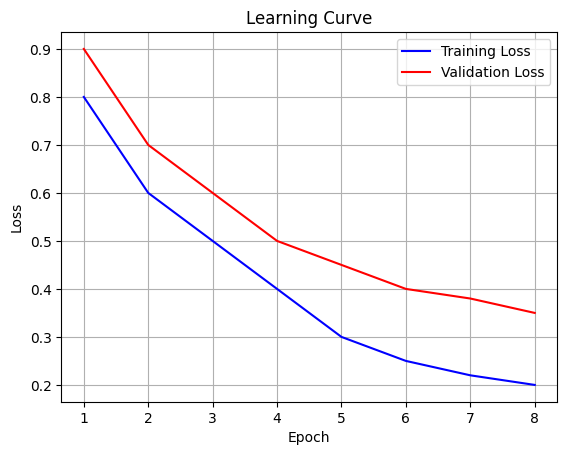

In [28]:
import matplotlib.pyplot as plt

train_loss = [0.8, 0.6, 0.5, 0.4, 0.3, 0.25, 0.22, 0.2] # Example loss values
val_loss = [0.9, 0.7, 0.6, 0.5, 0.45, 0.4, 0.38, 0.35]   # Example loss values

epochs = range(1, len(train_loss) + 1) # Assuming you have loss for each epoch

plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracyがとても低かったため、ノードを増やして計算してみたものがあるが、2時間以上の計算時間がかかり、エラーが出てしまったため、上のプログラムを以って一旦提出する。